In [3]:
import torchvision
from torchvision import datasets, transforms

# Transform (for CIFAR-10 example)
transform = transforms.ToTensor()

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Dataset description
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Get class names
classes = train_dataset.classes
print(f"Number of classes: {len(classes)}")
print(f"Class names: {classes}")


Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 50000
Number of testing samples: 10000
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified


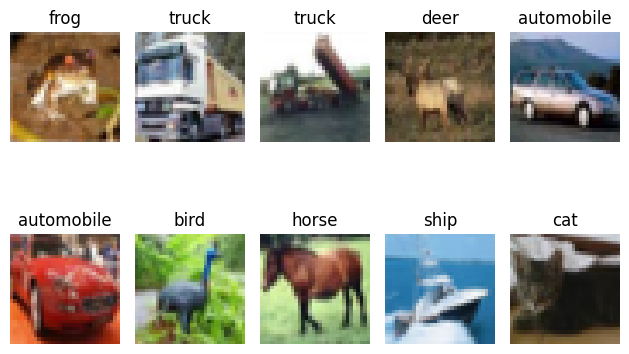

In [4]:
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms

# Transform
transform = transforms.ToTensor()

# Load Dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
classes = dataset.classes

# Show first 10 images and labels
for i in range(10):
    image, label = dataset[i]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.title(classes[label])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# -----------------------------
# Define the CNN architecture
# -----------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_filters=32, kernel_size=3, dropout_rate=0.25):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=kernel_size, padding=1)
        self.fc1 = nn.Linear((num_filters * 2) * 8 * 8, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)  # CIFAR-10 has 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except batch
        num = 1
        for s in size:
            num *= s
        return num

# -----------------------------
# Training function
# -----------------------------
def train_model(model, train_loader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)]))

# -----------------------------
# Transform and dataset
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# -----------------------------
# Hyperparameter Grid
# -----------------------------
param_grid = {
    'lr': [0.001],
    'batch_size': [64],
    'num_filters': [32],
    'kernel_size': [3],
    'dropout_rate': [0.3]
}
grid = list(ParameterGrid(param_grid))

# -----------------------------
# Grid Search Loop
# -----------------------------
for params in grid:
    print(f"\n🔍 Testing hyperparameters: {params}")
    model = SimpleCNN(num_filters=params['num_filters'], kernel_size=params['kernel_size'], dropout_rate=params['dropout_rate'])
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    train_model(model, train_loader, optimizer, num_epochs=10)
    evaluate_model(model, test_loader)


100%|██████████| 170M/170M [00:03<00:00, 46.9MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

🔍 Testing hyperparameters: {'batch_size': 64, 'dropout_rate': 0.3, 'kernel_size': 3, 'lr': 0.001, 'num_filters': 32}
Epoch 1, Loss: 1.4130
Epoch 2, Loss: 1.0535
Epoch 3, Loss: 0.9107
Epoch 4, Loss: 0.8104
Epoch 5, Loss: 0.7268
Epoch 6, Loss: 0.6562
Epoch 7, Loss: 0.5935
Epoch 8, Loss: 0.5344
Epoch 9, Loss: 0.4777
Epoch 10, Loss: 0.4386

Test Accuracy: 72.95%
Confusion Matrix:
[[829  17  40  15  19   6   9  10  26  29]
 [ 25 850  13   6   5   4  12   2  14  69]
 [ 78   5 572  65  88  67  78  29  12   6]
 [ 25  17  52 557  59 172  84  14   5  15]
 [ 19   3  49  63 680  28  86  57   9   6]
 [ 11   7  38 192  39 642  36  28   3   4]
 [  8   5  33  60  24  16 847   3   2   2]
 [ 21   4  33  42  57  75   9 743   1  15]
 [ 86  50  12  16  11   9  12   3 779  22]
 [ 41  94   3  17   7   9   7  12  14 796]]

Classification Report:
              precision    recall  f1-score   support

           0       0.

In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------
# Hyperparameters
# ----------------------------
batch_size = 64
lr = 0.001
num_epochs = 20

# ----------------------------
# CIFAR-10 Transforms
# ----------------------------
transform = transforms.Compose([
    transforms.Resize(224),  # ResNet18 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ----------------------------
# Load Datasets
# ----------------------------
train_dataset = datasets.CIFAR10(root='/kaggle/working/data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='/kaggle/working/data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ----------------------------
# Load Pretrained ResNet18
# ----------------------------
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes

# ----------------------------
# Set Device
# ----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# ----------------------------
# Optimizer
# ----------------------------
optimizer = optim.Adam(model.parameters(), lr=lr)

# ----------------------------
# Training Function
# ----------------------------
def train_model(model, train_loader, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------
# Evaluation Function
# ----------------------------
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"\n✅ Test Accuracy: {accuracy:.2f}%")
    print("\n📊 Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)]))

# ----------------------------
# Train and Evaluate
# ----------------------------
train_model(model, train_loader, optimizer, num_epochs)
evaluate_model(model, test_loader)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s] 


Epoch 1/20, Loss: 0.5525
Epoch 2/20, Loss: 0.3253
Epoch 3/20, Loss: 0.2225
Epoch 4/20, Loss: 0.1639
Epoch 5/20, Loss: 0.1259
Epoch 6/20, Loss: 0.0956
Epoch 7/20, Loss: 0.0850
Epoch 8/20, Loss: 0.0680
Epoch 9/20, Loss: 0.0589
Epoch 10/20, Loss: 0.0587
Epoch 11/20, Loss: 0.0445
Epoch 12/20, Loss: 0.0479
Epoch 13/20, Loss: 0.0430
Epoch 14/20, Loss: 0.0314
Epoch 15/20, Loss: 0.0418
Epoch 16/20, Loss: 0.0347
Epoch 17/20, Loss: 0.0277
Epoch 18/20, Loss: 0.0373
Epoch 19/20, Loss: 0.0261
Epoch 20/20, Loss: 0.0304

✅ Test Accuracy: 90.38%

📊 Confusion Matrix:
[[924   7   9   9   1   2   5   5  21  17]
 [  3 960   1   0   1   0   4   0   7  24]
 [ 36   0 875  20  27  10  19  10   1   2]
 [ 18   8  31 816  18  73  19  11   4   2]
 [  6   1  20  23 906  14  10  19   0   1]
 [  2   2  37  76  15 840   8  18   0   2]
 [  5   0  22  34   3   5 927   2   1   1]
 [  8   2   8   8  16  11   2 939   3   3]
 [ 34   7   4   9   0   3   2   2 917  22]
 [ 11  42   3   6   0   0   1   2   1 934]]

📄 Classific

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------
# Hyperparameters
# ----------------------------
batch_size = 64
lr = 0.001
num_epochs = 30

# ----------------------------
# CIFAR-10 Transforms
# ----------------------------
transform = transforms.Compose([
    transforms.Resize(224),  # ResNet18 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ----------------------------
# Load Datasets
# ----------------------------
train_dataset = datasets.CIFAR10(root='/kaggle/working/data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='/kaggle/working/data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ----------------------------
# Load Pretrained ResNet18
# ----------------------------
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes

# ----------------------------
# Set Device
# ----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# ----------------------------
# Optimizer
# ----------------------------
optimizer = optim.Adam(model.parameters(), lr=lr)

# ----------------------------
# Training Function
# ----------------------------
def train_model(model, train_loader, optimizer, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------
# Evaluation Function
# ----------------------------
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"\n✅ Test Accuracy: {accuracy:.2f}%")
    print("\n📊 Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)]))

# ----------------------------
# Train and Evaluate
# ----------------------------
train_model(model, train_loader, optimizer, num_epochs)
evaluate_model(model, test_loader)


100%|██████████| 170M/170M [00:16<00:00, 10.1MB/s] 


Extracting /kaggle/working/data/cifar-10-python.tar.gz to /kaggle/working/data
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 234MB/s]


Epoch 1/30, Loss: 0.5611
Epoch 2/30, Loss: 0.3256
Epoch 3/30, Loss: 0.2238
Epoch 4/30, Loss: 0.1659
Epoch 5/30, Loss: 0.1275
Epoch 6/30, Loss: 0.0984
Epoch 7/30, Loss: 0.0840
Epoch 8/30, Loss: 0.0675
Epoch 9/30, Loss: 0.0682
Epoch 10/30, Loss: 0.0514
Epoch 11/30, Loss: 0.0476
Epoch 12/30, Loss: 0.0491
Epoch 13/30, Loss: 0.0365
Epoch 14/30, Loss: 0.0427
Epoch 15/30, Loss: 0.0368
Epoch 16/30, Loss: 0.0314
Epoch 17/30, Loss: 0.0305
Epoch 18/30, Loss: 0.0316
Epoch 19/30, Loss: 0.0292
Epoch 20/30, Loss: 0.0264
Epoch 21/30, Loss: 0.0260
Epoch 22/30, Loss: 0.0285
Epoch 23/30, Loss: 0.0145
Epoch 24/30, Loss: 0.0258
Epoch 25/30, Loss: 0.0263
Epoch 26/30, Loss: 0.0227
Epoch 27/30, Loss: 0.0177
Epoch 28/30, Loss: 0.0231
Epoch 29/30, Loss: 0.0169
Epoch 30/30, Loss: 0.0181

✅ Test Accuracy: 90.94%

📊 Confusion Matrix:
[[935   4   6  17   3   1   2   4  16  12]
 [  5 958   0   5   1   2   0   0   3  26]
 [ 27   2 828  55  17  28  28   9   5   1]
 [  7   1   7 838  21  77  38   4   4   3]
 [  5   1  

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc_auc(model, loader, classes, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_true_1hot = np.eye(len(classes))[y_true]

    # AUC Score (macro average)
    auc = roc_auc_score(y_true_1hot, y_scores, multi_class='ovr')
    print(f"\n🔍 Overall AUC Score: {auc:.4f}")

    # Plot ROC Curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true_1hot[:, i], y_scores[:, i])
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC={roc_auc_score(y_true_1hot[:, i], y_scores[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve (CIFAR-10)')
    plt.legend()
    plt.grid()
    plt.show()
